In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import astropy.units as u

from model_spec import model_spec
import polModel
from draine_dust_2D import draine_dust

In [2]:
import sys
import os
sys.path.append("{}/Impol_Blue_HotDOGs/Impol_BHDs_repo/Calculations/Gas_and_dust/".format(os.path.expanduser('~')))
from free_electrons import free_electrons

## Spectrum, spectrum model and general pol model object

In [3]:
#Load the spectrum. 
spec, spec_model = model_spec()

In [4]:
#Load the general pol modeling objects. 
#import importlib
#importlib.reload(polModel_single_los)
pol_model = polModel.PolModel(spec, spec_model)

In [5]:
#Dictionaries to save the results.
xopt_all  = dict()
mod_p_all = dict() 

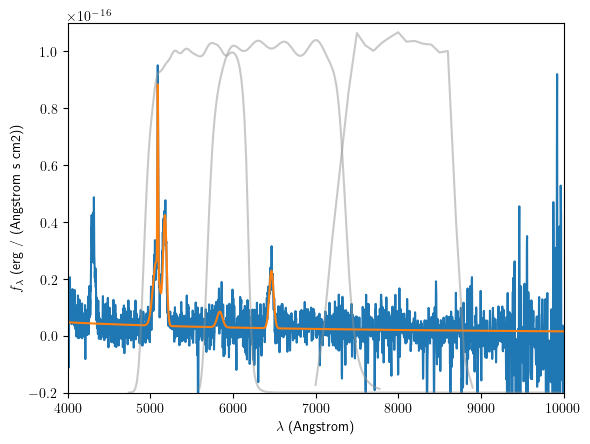

In [6]:
#Plot the spectrum, the best-fit model, and the filter curves.
pol_model.spec_plot()

In [7]:
#General plotting function
def pol_plot(mod_p, spec):

    data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    p_measured = data[:,0]
    p_unc = data[:,1]

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    for scat_type in mod_p.keys():
        if scat_type[-3:]=="LMC":
            fmt = '^'
        elif scat_type[-3:]=="SMC":
            fmt = 's'
        elif scat_type[-2:]=="MW":
            fmt = 'P'
        else:
            fmt='p'

        ax.plot(wave, mod_p[scat_type], fmt, label=scat_type)

    ax.legend(ncol=3)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Pure Gas Polarization

#### Same inclination for Continuum and Lines

In [8]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 1

        #Load the simple gas model. 
        self.gas_obj = free_electrons()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        costh = np.cos(a_pars[0]*u.deg)
        return self.gas_obj.pfrac(costh) * np.ones(len(lam))
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)


In [9]:
scat_obj = Gas_Gas()

##### Force the same polarization angle. 

In [10]:
x0 = np.array([0., 80.])
min_vals = np.array([0., 0.])
max_vals = np.array([0., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG0"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[-2.00535165e-24  2.76966934e+01]
19.13679692201329


##### Allow for different polarization angles.

In [11]:
x0 = np.array([30., 80.])
min_vals = np.array([0., 0.])
max_vals = np.array([90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[2.37332658e-03 2.76966934e+01]
19.136797064336957


#### Allow for independent inclination angle for lines and continuum.

In [12]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters.
        self.npar_a = 1
        self.npar_b = 1

        #Load the simple gas model. 
        self.gas_obj = free_electrons()

        return

    #Continuum polarization fraction
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        costh = np.cos(a_pars*u.deg)
        return self.gas_obj.pfrac(costh) * np.ones(len(lam))

    #Emission lines polarization fraction
    def pfrac_B(self, x, lam):
        b_pars = x[self.npar_a+1:self.npar_a+self.npar_b+1]
        costh = np.cos(b_pars*u.deg)
        return self.gas_obj.pfrac(costh) * np.ones(len(lam))


In [13]:
scat_obj = Gas_Gas()

In [14]:
x0 = np.array([30., 80., 80.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90, 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG2"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[44.77874015 26.9937808  44.15962197]
1.622075309965872e-11


In [15]:
gas_obj = free_electrons()
print(gas_obj.pfrac(np.cos(pol_model.xopt.x[1]*u.deg)))
print(gas_obj.pfrac(np.cos(pol_model.xopt.x[2]*u.deg)))

0.11483936034495014
0.32042376148645835


## Pure dust polarization

In [16]:
dust_types = ["SMC", "LMC", "MW"]

#### Require the same polarization for the continuum and the emission lines.

In [17]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type):

        #Save the input parameters.
        self.dust_type = dust_type

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters.
        self.npar_a = 1
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = draine_dust(self.dust_type)

        return

    #In this model, continuum and line polarization are the same. 
    def pfrac(self, x, lam):
        theta = x[1]
        return self.dust_obj.pfrac(lam.to(u.um).value, theta).flatten()

    #Continuum polarization fraction
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Emission lines polarization fraction
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)


##### Force the same polarization angle. 

In [18]:
for dust_type in dust_types:
    print(dust_type)
    
    scat_obj = Dust_Dust(dust_type)

    #Allow for forward and backward scattering solutions, as algorithm has issues converging from opposite starting points.
    for st in ("forward", "backward"):
        print(st)

        if st=="forward":
            x0 = np.array([0., 80.])
        elif st=="backward":
            x0 = np.array([0., 150.])
        min_vals = np.array([0., 0.])
        max_vals = np.array([0., 180.])
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD0_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
forward
`gtol` termination condition is satisfied.
[-6.38328147e-27  4.11569969e+01]
450.0419729495143
backward
`xtol` termination condition is satisfied.
[1.16937002e-26 1.47639568e+02]
764.2687981032728

LMC
forward
`xtol` termination condition is satisfied.
[1.83736832e-26 3.85655714e+01]
657.1085828528887
backward
`xtol` termination condition is satisfied.
[3.19926424e-26 1.46369900e+02]
260.28500782737956

MW
forward
`xtol` termination condition is satisfied.
[-2.87098723e-28  3.78956673e+01]
197.3850140430135
backward
`xtol` termination condition is satisfied.
[3.55770713e-26 1.45702834e+02]
531.429966071649



##### Allow for different polarization angles.

In [19]:
for dust_type in dust_types:
    print(dust_type)
    
    scat_obj = Dust_Dust(dust_type)

    #Allow for forward and backward scattering solutions, as algorithm has issues converging from opposite starting points.
    for st in ("forward", "backward"):
        print(st)

        if st=="forward":
            x0 = np.array([30., 80.])
        elif st=="backward":
            x0 = np.array([80., 150.])
        min_vals = np.array([0., 0.])
        max_vals = np.array([90., 180.])
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD1_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
forward
`xtol` termination condition is satisfied.
[77.74074196 69.79997619]
1.0814950160180747
backward
`xtol` termination condition is satisfied.
[ 41.15883294 143.86430116]
690.7991183500121

LMC
forward
`xtol` termination condition is satisfied.
[74.87733523 64.84306587]
174.47973157514235
backward
`xtol` termination condition is satisfied.
[ 64.63671935 127.2412519 ]
156.73410144159826

MW
forward
`gtol` termination condition is satisfied.
[73.33818784 64.95992597]
0.9487473993562873
backward
`xtol` termination condition is satisfied.
[ 56.39348908 127.55882737]
389.6938576975381



#### Allow for different scattering angles for continuum and lines.

In [20]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type):

        #Save the input parameters.
        self.dust_type = dust_type

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters.
        self.npar_a = 1
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = draine_dust(self.dust_type)

        return

    #Continuum polarization fraction
    def pfrac_A(self, x, lam):
        theta_A = x[1]
        return self.dust_obj.pfrac(lam.to(u.um).value, theta_A).flatten()

    #Emission lines polarization fraction
    def pfrac_B(self, x, lam):
        theta_B = x[1+self.npar_a]
        return self.dust_obj.pfrac(lam.to(u.um).value, theta_B).flatten()


In [21]:
for dust_type in dust_types:
    print(dust_type)
    
    scat_obj = Dust_Dust(dust_type)

    #Allow for forward and backward scattering solutions, as algorithm has issues converging from opposite starting points.
    for st in ("forward", "backward"):
        print(st)

        if st=="forward":
            x0 = np.array([30., 80., 80.])
        elif st=="backward":
            x0 = np.array([80., 150., 150.])
        min_vals = np.array([0., 0., 0.])
        max_vals = np.array([90., 180., 180.])
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD2_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
forward
`gtol` termination condition is satisfied.
[76.32682055 71.21654824 79.01166362]
1.407374090728528e-11
backward
`xtol` termination condition is satisfied.
[ 70.85107601 141.31823365 179.84152718]
716.363812282347

LMC
forward
`xtol` termination condition is satisfied.
[89.99744242 63.20574751 48.49031576]
164.8501319310459
backward
`xtol` termination condition is satisfied.
[ 80.94145119 127.46333649 151.38113272]
151.29070155951428

MW
forward
`gtol` termination condition is satisfied.
[73.21016911 66.74586304 72.98804875]
0.7700098760951161
backward
`xtol` termination condition is satisfied.
[ 62.27366259 127.63353674 163.02360838]
372.55107179721017



## Dust and Gas

Allow for the continuum to be scattered by dust and the emission lines to be scattered by gas. 

In [22]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type):

        #Save the input parameters.
        self.dust_type = dust_type

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters.
        self.npar_a = 1
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = draine_dust(self.dust_type)
        self.gas_obj = free_electrons()

        return

    #Continuum polarization fraction
    def pfrac_A(self, x, lam):
        theta_A = x[1]
        return self.dust_obj.pfrac(lam.to(u.um).value, theta_A).flatten()

    #Emission lines polarization fraction
    def pfrac_B(self, x, lam):
        theta_B = x[1+self.npar_a]
        costh = np.cos(theta_B*u.deg)
        return self.gas_obj.pfrac(costh) * np.ones(len(lam))


In [23]:
for dust_type in dust_types:
    print(dust_type)
    
    scat_obj = Gas_Dust(dust_type)

    #Allow for forward and backward scattering solutions, as algorithm has issues converging from opposite starting points.
    for st in ("forward", "backward"):
        print(st)

        if st=="forward":
            x0 = np.array([30., 80., 80.])
        elif st=="backward":
            x0 = np.array([30., 150., 80.])
        min_vals = np.array([0., 0., 0.])
        max_vals = np.array([90., 180., 90.])
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "GD_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun<xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
forward
`xtol` termination condition is satisfied.
[78.30515429 75.18988806 89.99855845]
10.252614185271064
backward
`xtol` termination condition is satisfied.
[4.71748751e-03 1.64937074e+02 4.50451294e+01]
789.6904492821104

LMC
forward
`xtol` termination condition is satisfied.
[89.99308721 63.16087426 37.33893983]
207.40899280429275
backward
`xtol` termination condition is satisfied.
[8.40929996e-03 1.43472825e+02 2.48795598e+01]
222.03272236632213

MW
forward
`xtol` termination condition is satisfied.
[70.068466   66.30472405 54.74707912]
12.559626596378344
backward
`xtol` termination condition is satisfied.
[4.40908928e-03 1.46224858e+02 3.15227949e+01]
525.4498950644053



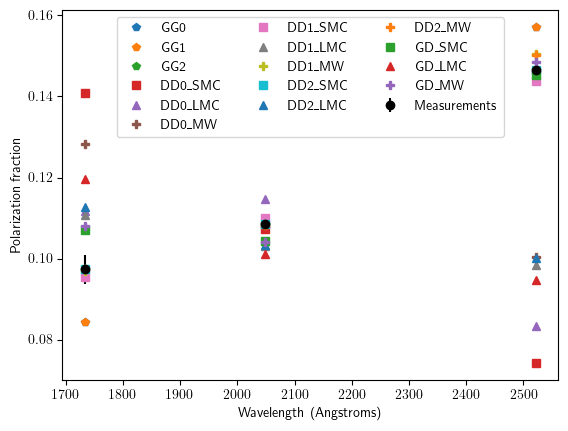

In [24]:
pol_plot(mod_p_all, spec)

In [25]:
#Rank solutions from best to worse. 
model_names = list(xopt_all.keys())
fun_all = np.zeros(len(model_names))
for i, mname in enumerate(model_names):
    fun_all[i] = xopt_all[mname].fun
k = np.argsort(fun_all)
for kk in k:
    mname = model_names[kk]
    print(mname, xopt_all[mname].fun, xopt_all[mname].x)

DD2_SMC 1.407374090728528e-11 [76.32682055 71.21654824 79.01166362]
GG2 1.622075309965872e-11 [44.77874015 26.9937808  44.15962197]
DD2_MW 0.7700098760951161 [73.21016911 66.74586304 72.98804875]
DD1_MW 0.9487473993562873 [73.33818784 64.95992597]
DD1_SMC 1.0814950160180747 [77.74074196 69.79997619]
GD_SMC 10.252614185271064 [78.30515429 75.18988806 89.99855845]
GD_MW 12.559626596378344 [70.068466   66.30472405 54.74707912]
GG0 19.13679692201329 [-2.00535165e-24  2.76966934e+01]
GG1 19.136797064336957 [2.37332658e-03 2.76966934e+01]
DD2_LMC 151.29070155951428 [ 80.94145119 127.46333649 151.38113272]
DD1_LMC 156.73410144159826 [ 64.63671935 127.2412519 ]
DD0_MW 197.3850140430135 [-2.87098723e-28  3.78956673e+01]
GD_LMC 207.40899280429275 [89.99308721 63.16087426 37.33893983]
DD0_LMC 260.28500782737956 [3.19926424e-26 1.46369900e+02]
DD0_SMC 450.0419729495143 [-6.38328147e-27  4.11569969e+01]
